In [11]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%%writefile ../src/cad_agent_from_scratch/mcp_eval_state.py

"""
State definitions for MCP execution and evaluation loop.

This state is used AFTER coding and BEFORE final acceptance.
"""

import operator
from typing_extensions import TypedDict, Annotated, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class MCPEvalState(TypedDict):
    """
    State for OpenSCAD MCP execution + evaluator–optimizer loop.
    """

    # Intended design (semantic ground truth)
    design_plan: str

    # Final OpenSCAD code from coding workflow
    openscad_code: str

    # MCP execution artifacts
    render_image: str | None
    stl_path: str | None
    execution_logs: str | None

    # Evaluator reasoning messages
    evaluator_messages: Annotated[Sequence[BaseMessage], add_messages]

    # Structured evaluator feedback
    evaluation_status: str | None   # "pass" | "fail"
    evaluation_feedback: str | None

    # Loop control
    iteration: int
    max_iterations: int


Overwriting ../src/cad_agent_from_scratch/mcp_eval_state.py


In [17]:
%%writefile ../src/cad_agent_from_scratch/mcp_eval_workflow.py

"""
MCP Execution + Evaluator Workflow (HTTP-based, Windows-safe)

Responsibilities:
- Connect to a RUNNING OpenSCAD MCP server over HTTP
- Execute OpenSCAD code via MCP tools
- Robustly extract render image (base64)
- Export STL
- Evaluate semantic + visual correctness
"""

import sys
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_mcp_adapters.client import MultiServerMCPClient

from cad_agent_from_scratch.mcp_eval_state import MCPEvalState
from cad_agent_from_scratch.logger import logging
from cad_agent_from_scratch.exception import CustomException


# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

evaluator_model = init_chat_model(model="gpt-4o")


# =============================================================================
# MCP CLIENT
# =============================================================================

_MCP_CLIENT: MultiServerMCPClient | None = None


def get_mcp_client() -> MultiServerMCPClient:
    global _MCP_CLIENT
    if _MCP_CLIENT is None:
        _MCP_CLIENT = MultiServerMCPClient(
            {
                "openscad": {
                    "transport": "http",
                    "url": "http://127.0.0.1:8000/mcp",
                }
            }
        )
    return _MCP_CLIENT


# =============================================================================
# NORMALIZE MCP RENDER OUTPUT
# =============================================================================

def extract_base64_image(render_result) -> str:
    if isinstance(render_result, list):
        if not render_result:
            raise RuntimeError("Empty render result from MCP")
        render_result = render_result[0]

    if isinstance(render_result, dict):
        if "text" in render_result:
            render_result = render_result["text"]
        else:
            raise RuntimeError(f"Unexpected render dict: {render_result}")

    if not isinstance(render_result, str):
        raise RuntimeError(f"Unsupported render output type: {type(render_result)}")

    if not render_result.startswith("data:image/png;base64,"):
        raise RuntimeError(f"Render failed: {render_result[:200]}")

    return render_result.split(",", 1)[1]


# =============================================================================
# MCP EXECUTION NODE
# =============================================================================

async def run_openscad_mcp(
    state: MCPEvalState,
) -> Command[Literal["evaluator"]]:

    try:
        client = get_mcp_client()
        tools = await client.get_tools()
        tools_by_name = {tool.name: tool for tool in tools}

        await tools_by_name["create_openscad_script"].ainvoke(
            {"script_content": state["openscad_code"]}
        )

        await tools_by_name["save_openscad_script"].ainvoke(
            {"filename": "model.scad"}
        )

        raw_render = await tools_by_name["view_render"].ainvoke(
            {"view": "isometric"}
        )
        render_image = extract_base64_image(raw_render)

        raw_stl = await tools_by_name["export_model_to_stl"].ainvoke(
            {"filename": "model"}
        )

        if isinstance(raw_stl, list):
            raw_stl = raw_stl[0] if raw_stl else None

        stl_path = None
        if isinstance(raw_stl, str) and "to" in raw_stl:
            stl_path = raw_stl.split("to", 1)[1].split("(")[0].strip()

    except Exception as e:
        logging.exception("MCP execution failed")
        raise CustomException(e, sys)

    return Command(
        update={
            "render_image": render_image,
            "stl_path": stl_path,
            "execution_logs": "OpenSCAD MCP execution successful",
        },
        goto="evaluator",
    )


# =============================================================================
# EVALUATOR NODE (PLAN + CODE + IMAGE)
# =============================================================================

async def evaluator(
    state: MCPEvalState,
) -> Command[Literal["__end__"]]:

    if not state.get("render_image"):
        raise CustomException("Missing render image", sys)

    messages = [
        SystemMessage(
            content=(
                "You are a CAD evaluator.\n\n"
                "You MUST compare THREE things:\n"
                "1. DESIGN PLAN (ground truth)\n"
                "2. OpenSCAD code\n"
                "3. Rendered image\n\n"
                "Rules:\n"
                "- FAIL if any dimension deviates from the plan\n"
                "- FAIL if proportions do not match\n"
                "- PASS only if plan, code, and image all agree\n\n"
                "Be strict."
            )
        ),
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": (
                        f"DESIGN PLAN:\n{state['design_plan']}\n\n"
                        f"OPENSCAD CODE:\n{state['openscad_code']}"
                    ),
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{state['render_image']}"
                    },
                },
            ]
        ),
    ]

    response = await evaluator_model.ainvoke(messages)
    status = "pass" if "pass" in response.content.lower() else "fail"

    return Command(
        update={
            "evaluation_status": status,
            "evaluation_feedback": response.content,
            "iteration": state["iteration"] + 1,
        },
        goto=END,
    )


# =============================================================================
# GRAPH
# =============================================================================

builder = StateGraph(MCPEvalState)
builder.add_node("mcp_execution", run_openscad_mcp)
builder.add_node("evaluator", evaluator)

builder.add_edge(START, "mcp_execution")
builder.add_edge("mcp_execution", "evaluator")

mcp_eval_workflow = builder.compile()


Overwriting ../src/cad_agent_from_scratch/mcp_eval_workflow.py


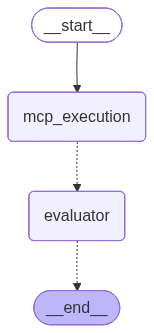

In [18]:
from langgraph.checkpoint.memory import InMemorySaver
from cad_agent_from_scratch.mcp_eval_workflow import builder
from IPython.display import Image, display

checkpointer = InMemorySaver()

mcp_agent = builder.compile(checkpointer=checkpointer)

display(
    Image(mcp_agent.get_graph(xray=True).draw_mermaid_png())
)


In [19]:
from cad_agent_from_scratch.mcp_eval_workflow import mcp_eval_workflow

thread = {"configurable": {"thread_id": "mcp-5"}}

mcp_state = {
    "design_plan": "A solid cube with dimensions 50 x 50 x 50 units",
    "openscad_code": "cube([50,5000,50], center=true);",
    "render_image": None,
    "stl_path": None,
    "execution_logs": None,
    "evaluator_messages": [],
    "evaluation_status": None,
    "evaluation_feedback": None,
    "iteration": 0,
    "max_iterations": 3,
}

result = await mcp_eval_workflow.ainvoke(mcp_state, config=thread)

print("STATUS:", result["evaluation_status"])
print("FEEDBACK:", result["evaluation_feedback"])

STATUS: fail
FEEDBACK: Here is the evaluation:

1. **Design Plan**: A solid cube with dimensions 50 x 50 x 50 units.

2. **OpenSCAD Code**: `cube([50,5000,50], center=true);`
   - Dimensions: 50 x 5000 x 50 units
   - This does not match the design plan.

3. **Rendered Image**: Shows a significantly elongated shape, not a cube.

**Conclusion**: FAIL. The code and the rendered image do not match the design plan. The dimensions are incorrect.
